### Goals 

This is the intuition behind `ReAct` a general agent architecture.
- `act` -let the model call specific tool
- `boserve` -pass the tool ouput back to the model
- `reason` -let the model reason about the tool output to decie what to do next(e.g, call another tool or just respond directly)


In [1]:
### Prepare environment
import os, getpass
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}:")
# set proxy
_set_env("PROXY_VALUE")
proxy = os.getenv("PROXY_VALUE")
for proxy_var in ['HTTP_PROXY', 'HTTPS_PROXY', 'http_proxy', 'https_proxy']:
    os.environ[proxy_var] = proxy
# GOOGLE API KEY
_set_env("GOOGLE_API_KEY")

In [2]:
%%capture --no-stderr
%pip install --quiet -U langchain-google-genai langchain_core langgraph

Here, we'll use LangSmith for tracing.
We'll log to project `langchain-academy`

In [3]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

LANGCHAIN_API_KEY: ········


In [24]:
from langchain_google_genai import ChatGoogleGenerativeAI

# This will be a tool
def multiply(a: int, b: int) -> int:
    """
    Multiply a and b.
    Args:
        a: first in
        b: second int
    
    """
    return a * b

def add(a: int, b: int) -> int:
    """
    Adds a and b.
    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """
    Divided a and b.
    Args:
        a: first int
        b: second int
    """
    return a / b


tools = [add, multiply, divide]
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0.2,
    max_tokens=512,
    timeout=None,
    max_retries=2
)
# For this ipynb we set parallet tool calling to false as math generally is doen sequentially (gemin dont' need)
# llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)
llm_with_tools = llm.bind_tools(tools)



Let's create our LLM and prompt it with the overall desired agent behavior.

In [20]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Assistant Node
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

As before, we use `MessagesState` and define a `Tools` node with our list of tools.
The `Assistant` node is just our model with bound tools.
We create a graph with `Asistant` and `Tools` nodes.
We add `tools_condition` edge, which routers to `End` or to `Tools` based on whether the `Assistant` calls a tool.
Now, we add one new step:
We connect the `Tools` node back to the `Assistant`, forming a loop.
- After the `assistant` node executes, `tools_condition` checkds if the model's output is a tool call.
- If it is a tool call, the flow is directed to the `tools` node.
- This loop continues as long as the model decides to call tools.
- If the model response is not a tool call, the flow is directed to `END` , terminating the process.

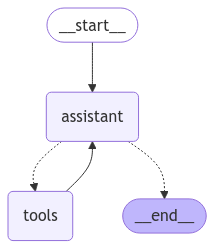

In [25]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph 
builder = StateGraph(MessagesState)


# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not atool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [26]:
### Test chat with assistant
messages = [HumanMessage(content="Add 3 nd 4. Multiply the output by 2. Divide the output by 5")]
messages = react_graph.invoke({"messages": messages})

In [27]:
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 nd 4. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (397fd90c-e5f3-499c-9312-0af608427aed)
 Call ID: 397fd90c-e5f3-499c-9312-0af608427aed
  Args:
    a: 3.0
    b: 4.0
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (35b96c71-883c-44ce-8a02-9a376268664a)
 Call ID: 35b96c71-883c-44ce-8a02-9a376268664a
  Args:
    a: 7.0
    b: 2.0
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  divide (36e2ae39-fdad-4045-af55-abf186837ff0)
 Call ID: 36e2ae39-fdad-4045-af55-abf186837ff0
  Args:
    a: 14.0
    b: 5.0
=========